# Import Module

In [1]:
import torch
import glob
import warnings 
warnings.filterwarnings('ignore')

import random
import PIL
import cv2
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


# Set seed and config

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 224,
     'EPOCHS' : 30,
     'BATCH_SIZE' : 64,
     'LR' : 0.0001,
     'model_save_path' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/Crop_Augmented.pt"}

In [5]:
seed_everything(CFG['SEED'])

# Get Data Path

In [6]:
def get_path(path):
    normal=[]
    vir=[]
    bact=[]

    normal_label = []
    vir_label = []
    bact_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}/"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0,0]))

        elif t=='VIRUS':
            vir_path = f"{path}{t}/"
            for vir_data in glob.glob(vir_path + "/*.jpeg"):
                vir.append(vir_data)
                vir_label.append(np.array([0,1,0]))
                
        elif t=='BACTERIA':
            bact_path = f"{path}{t}/"
            for bact_data in glob.glob(bact_path + "/*.jpeg"):
                bact.append(bact_data)
                bact_label.append(np.array([0,0,1]))

    return normal, vir, bact, normal_label, vir_label, bact_label

#Train
train_path = f"/home/user1/바탕화면/HJ/chest_xray/train/"
train_normal, train_vir, train_bact, train_normal_label, train_vir_label, train_bact_label = get_path(train_path)

# Test
test_path = f"/home/user1/바탕화면/HJ/chest_xray/test/"
test_normal, test_vir, test_bact, test_normal_label, test_vir_label, test_bact_label = get_path(test_path)

In [7]:
print(f"Train Normal : {len(train_normal)}\nTrain Virus : {len(train_vir)}\nTrain Bacteria : {len(train_bact)}\n")
print(f"Test normal : {len(test_normal)}\nTest Virus : {len(test_vir)}\nTest Bacteria : {len(test_bact)}\n")

Train Normal : 1341
Train Virus : 1345
Train Bacteria : 2530

Test normal : 234
Test Virus : 148
Test Bacteria : 242



In [8]:
train_data = train_normal + train_vir + train_bact
train_label = train_normal_label + train_vir_label + train_bact_label

train_aug = train_normal + train_vir
train_aug_label = train_normal_label + train_vir_label

test_data = test_normal + test_vir + test_bact
test_label = test_normal_label + test_vir_label + test_bact_label

/home/user1/바탕화면/HJ/chest_xray/train/NORMAL/NORMAL2-IM-0501-0001.jpeg
Image size => (1503, 1782, 3)


(-0.5, 1781.5, 1502.5, -0.5)

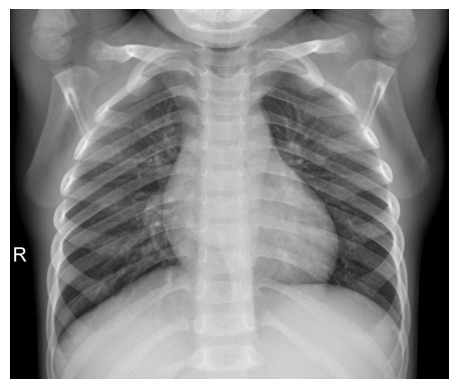

In [9]:
n = random.randint(0, len(train_data)-1)
print(f"{train_data[n]}")
img = cv2.imread(train_data[n])
print(f"Image size => {img.shape}")
plt.imshow(img)
plt.axis('off')

In [10]:
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

In [11]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.fc2 = nn.Linear(in_features=1000, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Make Dataset

In [12]:
class Customdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.9 * w)
    
        if dimension == 2:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w])
        else:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w, :])
    
        return cropped_image  # PIL Image 반환

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)
        img = self.__crop__(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.from_numpy(label)

In [13]:
class Augmentedataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.9 * w)
    
        if dimension == 2:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w])
        else:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w, :])
    
        return cropped_image  # PIL Image 반환

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)
        img = self.__crop__(img)
        img = torchvision.transforms.functional.hflip(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.from_numpy(label)

In [14]:
train_crop_dataset = Customdataset(train_data, train_label, train_transform)
train_aug_dataset = Augmentedataset(train_aug, train_aug_label, train_transform)
train_dataset = train_crop_dataset + train_aug_dataset
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [15]:
f, l = next(iter(train_dataloader))

In [16]:
print(f"Feature shape : {f[0].shape}")

Feature shape : torch.Size([3, 224, 224])


In [17]:
# from torchvision.transforms.functional import to_pil_image
# a = train_crop_dataset[0][0]
# b = train_aug_dataset[0][0]

# plt.subplot(1,2,1)
# plt.imshow(to_pil_image(a), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(to_pil_image(b), cmap='gray')

# len(train_dataset)  # 7902 (Normal & Virus: HFlip augmentation)

# Define Model

In [18]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.fc2 = nn.Linear(in_features=1000, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [19]:
model = Model().to(device)
model = nn.DataParallel(model).to(device)

# Define Loss, Optimizer

In [20]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])

# Training

In [21]:
def train_loop(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X,y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 20 == 0:
                print(f"Batch loss : {(loss/size):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [22]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, CFG['model_save_path'])

Start epoch : 1
Batch loss : 0.00932 0/124
Batch loss : 0.00816 20/124
Batch loss : 0.00709 40/124
Batch loss : 0.00658 60/124
Batch loss : 0.00702 80/124
Batch loss : 0.00612 100/124
Batch loss : 0.00633 120/124
Loss : 0.89000 ACC : 66.14%
End epoch : 1
Epoch time : 4.0 min 6.854300498962402 sec

Start epoch : 2
Batch loss : 0.00599 0/124
Batch loss : 0.00584 20/124
Batch loss : 0.00678 40/124
Batch loss : 0.00541 60/124
Batch loss : 0.00625 80/124
Batch loss : 0.00613 100/124
Batch loss : 0.00599 120/124
Loss : 0.74946 ACC : 80.28%
End epoch : 2
Epoch time : 4.0 min 3.6693525314331055 sec

Start epoch : 3
Batch loss : 0.00577 0/124
Batch loss : 0.00557 20/124
Batch loss : 0.00526 40/124
Batch loss : 0.00530 60/124
Batch loss : 0.00588 80/124
Batch loss : 0.00560 100/124
Batch loss : 0.00573 120/124
Loss : 0.70504 ACC : 84.66%
End epoch : 3
Epoch time : 4.0 min 4.834295272827148 sec

Start epoch : 4
Batch loss : 0.00513 0/124
Batch loss : 0.00539 20/124
Batch loss : 0.00525 40/124
Bat

Text(0.5, 1.0, 'Train Loss')

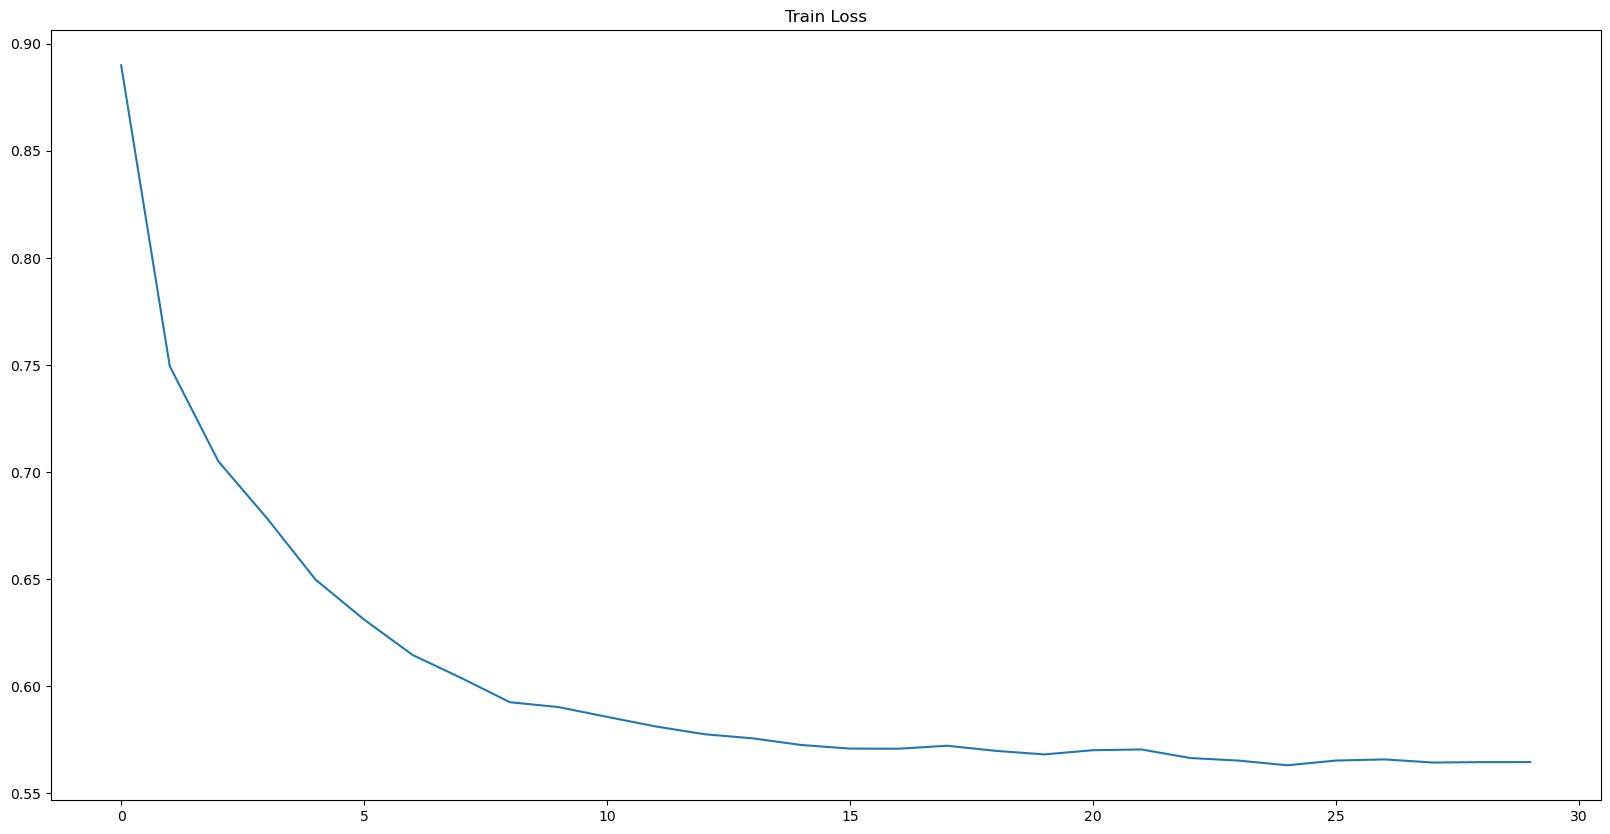

In [23]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist, label='train_loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Acc')

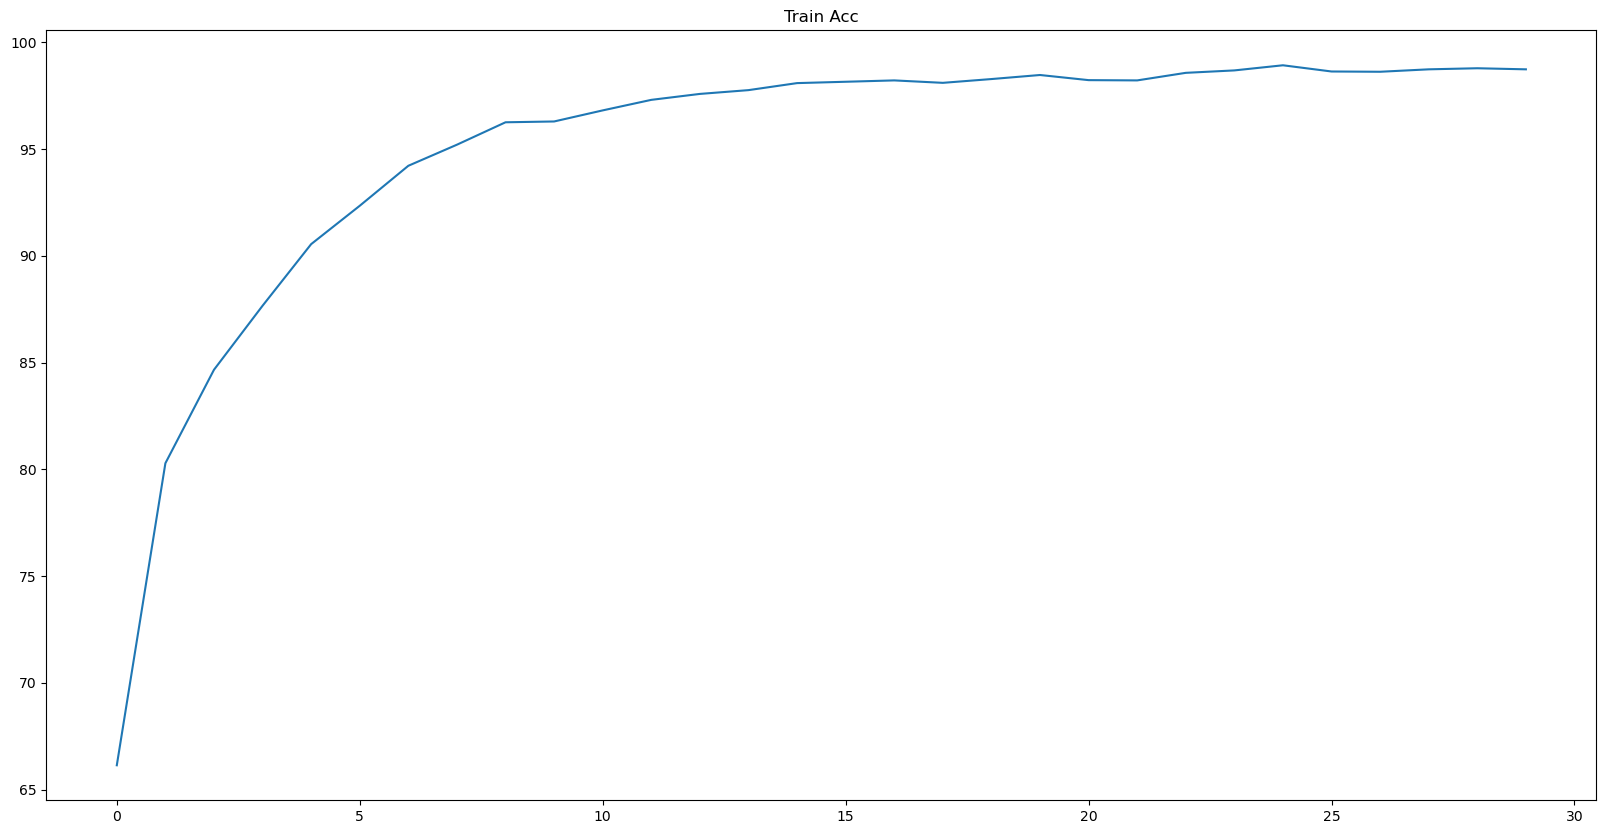

In [24]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist, label='train_acc')
plt.title('Train Acc')

# TEST

In [25]:
test_dataset = Customdataset(test_data, test_label, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [26]:
def test_loop(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (X,y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output = model(X)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [27]:
label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, label, pred  = test_loop(test_dataloader, model, CFG['model_save_path'])

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

In [29]:
OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

<Axes: >

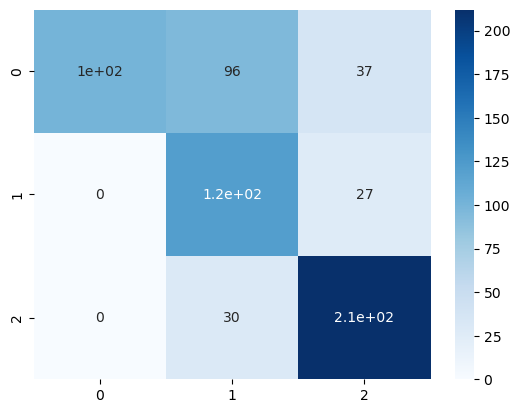

In [30]:
cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')